In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Compose, Resize
import time
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor
import warnings
warnings.filterwarnings("ignore")
import torchmetrics

In [12]:
class MyModule(nn.Module):
    def __init__(self, lr=0.0001):
        super().__init__()
        self.learning_rate = lr
    

    def forward(self, x):
        out = self.model(x)
        return out

    def init_cnn(self, module):  #@save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            #nn.init.xavier_uniform_(module.weight)
            nn.init.kaiming_uniform_(module.weight, a=2.0**0.5)

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()

    def loss_fn(self, logits, y):
        loss = nn.functional.cross_entropy(logits, y)
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)


In [13]:
class AlexNet(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        
        self.apply(self.init_cnn)
        self.configure_optimizers()


In [14]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        transforms = Compose([ToTensor(), Resize(size = (224, 224))])
        self.train = datasets.FashionMNIST(root='data', train=True, transform=transforms)
        self.val = datasets.FashionMNIST(root='data', train=False, transform=transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 1024, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 1024, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 59, 10)

In [65]:
model = AlexNet()

torch.Size([1024, 1, 224, 224]) torch.Size([1024])


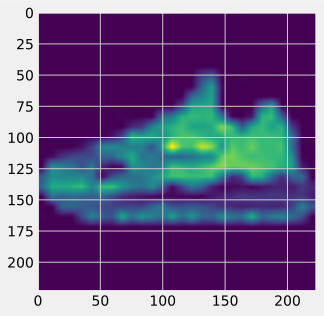

In [55]:
for x, y in data.train_dl:
    print (x.shape, y.shape)
    plt.imshow(x[0].view(224, 224))
    break

In [28]:
x = torch.randn((1, 1, 224, 224))
y = torch.tensor([2])

logits = model(x)
print (logits)
print (model.loss_fn(logits, y))
print (model.accuracy(logits, y))


tensor([[-0.0057, -0.0093,  0.0382, -0.0129, -0.0012,  0.0222, -0.0094, -0.0256,
          0.0278, -0.0350]], grad_fn=<AddmmBackward0>)
tensor(2.2635, grad_fn=<NllLossBackward0>)
tensor(1.)


In [40]:
# Test Network
print (x.shape, 'Initial x')

y = x
for layer in model.model:
    y = layer(y)
    print (y.shape, ' after ', layer)

torch.Size([1, 1, 224, 224]) Initial x
torch.Size([1, 96, 54, 54])  after  Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
torch.Size([1, 96, 54, 54])  after  ReLU()
torch.Size([1, 96, 26, 26])  after  MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 256, 26, 26])  after  Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
torch.Size([1, 256, 26, 26])  after  ReLU()
torch.Size([1, 256, 12, 12])  after  MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 384, 12, 12])  after  Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 384, 12, 12])  after  ReLU()
torch.Size([1, 384, 12, 12])  after  Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 384, 12, 12])  after  ReLU()
torch.Size([1, 256, 12, 12])  after  Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 256, 12, 12])  after  ReLU

In [46]:
1 * 224 * 224, 96* 54* 54, 96* 26* 26, 256 * 26 * 26, 256*12*12, 384* 12* 12

(50176, 279936, 64896, 173056, 36864, 55296)

In [17]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = AlexNet().to(device)
#model = AlexNet()
for batch in data.train_dl:
    x, y = batch
    x, y = x.to(device), y.to(device)
    logits = model(x)
    
    train_loss = model.loss_fn(logits, y)

    print (f'Training loss: {train_loss.item():.4f}')

    model.optimizer.zero_grad(set_to_none=True)
    train_loss.backward()
    model.optimizer.step()



Using mps device
Training loss: 2.3029
Training loss: 2.3002
Training loss: 2.2953
Training loss: 2.2832
Training loss: 2.2609
Training loss: 2.2155
Training loss: 2.1338
Training loss: 1.9816
Training loss: 1.8019


KeyboardInterrupt: 

In [10]:
torch.manual_seed(42)
n_embd = 10
n_hidden = 200
batch_size = 1024


class Classifier3(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(10))

        self.batch_size = 1024
        self.learning_rate = 0.0004
        #self.train_acc = torchmetrics.Accuracy(
        #    task='multiclass', num_classes=10)
        self.model(next(iter(data.train_dl))[0])
        self.apply(self.init_cnn)

    def init_cnn(self, module):  # @save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            # nn.init.xavier_uniform_(module.weight)
            nn.init.kaiming_uniform_(module.weight, a=2.0**0.5)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        #self.train_acc(logits, y)
        self.log("train_loss", loss, prog_bar=False,
                 on_step=False, on_epoch=True)
        #self.log('train_acc', self.train_acc, prog_bar=True,
        #         on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        # self.log('train_loss', loss)
        self.log("val_loss", loss, prog_bar=True,
                 on_step=False, on_epoch=True)

        return loss

    def predict_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # x, y = batch
        x = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    optimizer, patience=10)
        #lr_scheduler = {"scheduler": scheduler,
        #                "interval": "epoch", "monitor": "val_loss"}
        return optimizer #[optimizer], [lr_scheduler]

    def init_cnn(self,module):  # @save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            nn.init.kaiming_uniform_(module.weight, a=2.0**0.5)


model = Classifier3()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 82 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/jsmidt/Documents/AI/scratch/d2l/.lr_find_be047c4d-b012-47b0-af88-eb8ade72a200.ckpt
Restored all states from the checkpoint file at /Users/jsmidt/Documents/AI/scratch/d2l/.lr_find_be047c4d-b012-47b0-af88-eb8ade72a200.ckpt


0.0004365158322401656


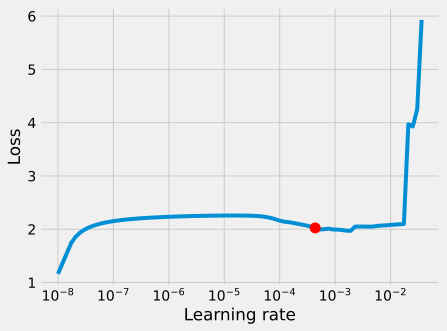

In [18]:
# run learning rate finder, results override hparams.learning_rate
trainer = pl.Trainer(auto_lr_find=True)

# call tune to find the lr
#lr_finder = trainer.tune(makemore, train_dataloaders=data)
lr_finder = trainer.tuner.lr_find(model, train_dataloaders=data.train_dl)

# Results can be found in
#print(lr_finder.results)
print (lr_finder.suggestion())

fig = lr_finder.plot(suggest=True)
fig.show()

In [11]:
#lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(max_epochs=10, accelerator="mps", callbacks=[TQDMProgressBar()])
trainer.fit(model=model, train_dataloaders=data.train_dl, val_dataloaders=data.val_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 46.8 M
-------------------------------------
46.8 M    Trainable params
0         Non-trainable params
46.8 M    Total params
187.059   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]